## Brownlee adapted 3_24

https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/

In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib.pyplot as plt
import numpy
from numpy import concatenate
#import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# plot size
plt.rcParams["figure.figsize"] = (15,10)

***

## Part 1 -- Data preparation
We load the price, volume, transaction, trades per minute, bidask, epu_idx and semantic (tweet) score from the spreadsheet we combined them into.

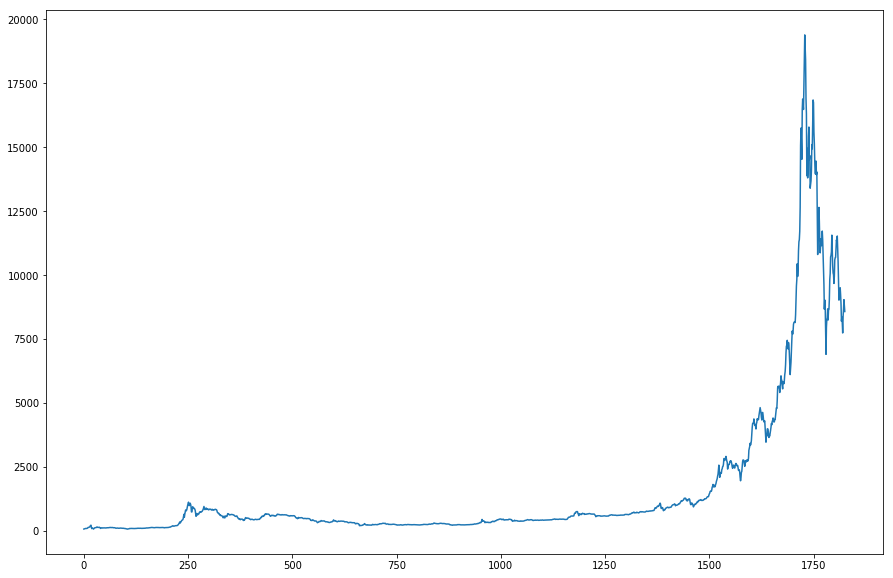

In [4]:
# get the data
fname='btc_new_3_24.csv'
df = pd.read_csv(fname)
df['price'].plot()
plt.show()

In [5]:
# we must drop any NaN rows for LSTM to run
df.dropna(inplace=True)

### Brownlee functions
These are some of the functions Brownlee wrote to transform and un-transform the data. We'll be using adapted versions for our model. We won't use all of them. Unlike prior runs, we will use his differencing function to make the data stationary before scaling it later in the process.

In [6]:
# date-time parsing function for loading the dataset; NOT USED
def parser(x):
	return datetime.strptime(x, '%Y-%b')

# frame a sequence as a supervised learning problem; NOT USED
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
# this base model is the one that worked best for me
# it uses hidden layers of 100, 20, 10 and 5 neurons
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(10, return_sequences=True))
    model.add(LSTM(5))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# this function runs the lstm model for the repeat experiment function below
# I've commented out the data prep part, since we've done that already
# run a repeated experiment
def experiment(n_repeats, batch_size=1, n_epochs=1, n_neurons=1):
	# transform data to be stationary
	# raw_values = series.values
	# diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	# supervised = timeseries_to_supervised(diff_values, features)
	# supervised_values = supervised.values[features:,:]
	# split data into train and test-sets
	# train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
	# transform the scale of the data
	# scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(n_repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, batch_size, n_epochs, n_neurons)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-600:], predictions))
		print('')
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		print('')
		error_scores.append(rmse)
	return error_scores


# this function can be used to configure and run multiple trials of a model
def run():
	n_repeats = 2
	batch_size = 1
	n_epochs = 10
	n_neurons = 100
	# run the experiment
	results = pd.DataFrame()
	results['results'] = experiment(n_repeats, batch_size, n_epochs, n_neurons)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment.csv', index=False)
    # save boxplot
	results.boxplot()
	plt.show()
 
# to run it
# run()


In [7]:
df.head()

,day,epu_idx,price,volume,bidask,tpm,trans,exp_sem
0,3/24/13,126.08,68.287939,3.361108e+06,0.761886,2.203646,51335,0.24065
1,3/25/13,178.57,73.648607,6.917269e+06,0.978241,2.824132,48993,0.20230
2,3/26/13,163.29,77.090928,5.322638e+06,0.931310,2.560417,49061,0.00000
3,3/27/13,177.06,85.256510,7.356470e+06,1.033937,3.198785,53207,0.21230
4,3/28/13,72.92,90.658741,1.477020e+07,1.555560,5.049826,60989,0.20240


### Difference the data
Several variables are not stationary. For LSTM to work, the have to be differenced. We do that for transactions, bid-ask spread, volume and trades per minute. We will difference price in the next step so it synchronizes with the Brownlee functions.

In [8]:
df_temp = df[['trans', 'bidask', 'volume', 'tpm']].diff(1,0)

In [9]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1825
Data columns (total 4 columns):
trans     1825 non-null float64
bidask    1825 non-null float64
volume    1825 non-null float64
tpm       1825 non-null float64
dtypes: float64(4)
memory usage: 71.3 KB


### Put it back together

In [10]:
# concatenate the data, rename columns
new_df = pd.DataFrame(pd.concat([df_temp, df[['price','epu_idx', 'exp_sem']]], axis=1))

In [11]:
new_df.head()

,trans,bidask,volume,tpm,price,epu_idx,exp_sem
0,NaN,NaN,NaN,NaN,68.287939,126.08,0.24065
1,-2342.0,0.216354,3556161.550,0.620486,73.648607,178.57,0.20230
2,68.0,-0.046930,-1594630.877,-0.263715,77.090928,163.29,0.00000
3,4146.0,0.102627,2033831.837,0.638368,85.256510,177.06,0.21230
4,7782.0,0.521623,7413732.351,1.851042,90.658741,72.92,0.20240


### Create the 1-day lagged price as target variable 'y'
We are trying to predict the next day's price based on the data we know today. The next series of steps adds our features together with y = t+1. So now we have the next day's true price (y) and today's knowledge (X) in each observation.

#### Step 1: Difference the price

In [12]:
# first we have to difference the price
# we're using Brownlee's function to do this so we can undifference it later
raw_values = new_df['price'].values
diff_values = difference(raw_values, 1)
diff_values.head()

0    5.360668
1    3.442321
2    8.165582
3    5.402231
4   -0.559414
dtype: float64

In [13]:
len(diff_values)

1825

In [14]:
# check it
new_df['price'].diff(1).head()

0         NaN
1    5.360668
2    3.442321
3    8.165582
4    5.402231
Name: price, dtype: float64

#### Step 2: Create our lagged ahead target price 'y'

In [15]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)

In [16]:
supervised[0:6]

,0,0
0,NaN,5.360668
1,5.360668,3.442321
2,3.442321,8.165582
3,8.165582,5.402231
4,5.402231,-0.559414
5,-0.559414,1.400072


#### Step 3: Combine with our other features

In [17]:
new_df.head(5)

,trans,bidask,volume,tpm,price,epu_idx,exp_sem
0,NaN,NaN,NaN,NaN,68.287939,126.08,0.24065
1,-2342.0,0.216354,3556161.550,0.620486,73.648607,178.57,0.20230
2,68.0,-0.046930,-1594630.877,-0.263715,77.090928,163.29,0.00000
3,4146.0,0.102627,2033831.837,0.638368,85.256510,177.06,0.21230
4,7782.0,0.521623,7413732.351,1.851042,90.658741,72.92,0.20240


In [18]:
# concatenate the data, rename columns
df2 = pd.DataFrame(pd.concat([new_df, supervised], axis=1))

In [19]:
df2.columns.values[7] = "d-price"
df2.columns.values[8] = "y"

In [20]:
df2.head()

,trans,bidask,volume,tpm,price,epu_idx,exp_sem,d-price,y
0,NaN,NaN,NaN,NaN,68.287939,126.08,0.24065,NaN,5.360668
1,-2342.0,0.216354,3556161.550,0.620486,73.648607,178.57,0.20230,5.360668,3.442321
2,68.0,-0.046930,-1594630.877,-0.263715,77.090928,163.29,0.00000,3.442321,8.165582
3,4146.0,0.102627,2033831.837,0.638368,85.256510,177.06,0.21230,8.165582,5.402231
4,7782.0,0.521623,7413732.351,1.851042,90.658741,72.92,0.20240,5.402231,-0.559414


In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1825
Data columns (total 9 columns):
trans      1825 non-null float64
bidask     1825 non-null float64
volume     1825 non-null float64
tpm        1825 non-null float64
price      1826 non-null float64
epu_idx    1826 non-null float64
exp_sem    1826 non-null float64
d-price    1824 non-null float64
y          1825 non-null float64
dtypes: float64(9)
memory usage: 142.7 KB


In [22]:
# delete old price column
df2.drop(['price'], axis=1, inplace=True)

#### Step 4: Inspect

In [23]:
# inspect; we should have seven features (X) and our target(y)
df2.head()

,trans,bidask,volume,tpm,epu_idx,exp_sem,d-price,y
0,NaN,NaN,NaN,NaN,126.08,0.24065,NaN,5.360668
1,-2342.0,0.216354,3556161.550,0.620486,178.57,0.20230,5.360668,3.442321
2,68.0,-0.046930,-1594630.877,-0.263715,163.29,0.00000,3.442321,8.165582
3,4146.0,0.102627,2033831.837,0.638368,177.06,0.21230,8.165582,5.402231
4,7782.0,0.521623,7413732.351,1.851042,72.92,0.20240,5.402231,-0.559414


In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1825
Data columns (total 8 columns):
trans      1825 non-null float64
bidask     1825 non-null float64
volume     1825 non-null float64
tpm        1825 non-null float64
epu_idx    1826 non-null float64
exp_sem    1826 non-null float64
d-price    1824 non-null float64
y          1825 non-null float64
dtypes: float64(8)
memory usage: 128.4 KB


In [25]:
# we must drop any NaN rows for LSTM to run
df2.dropna(inplace=True)

In [26]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1824 entries, 1 to 1824
Data columns (total 8 columns):
trans      1824 non-null float64
bidask     1824 non-null float64
volume     1824 non-null float64
tpm        1824 non-null float64
epu_idx    1824 non-null float64
exp_sem    1824 non-null float64
d-price    1824 non-null float64
y          1824 non-null float64
dtypes: float64(8)
memory usage: 128.2 KB


In [27]:
df2.head()

,trans,bidask,volume,tpm,epu_idx,exp_sem,d-price,y
1,-2342.0,0.216354,3556161.550,0.620486,178.57,0.202300,5.360668,3.442321
2,68.0,-0.046930,-1594630.877,-0.263715,163.29,0.000000,3.442321,8.165582
3,4146.0,0.102627,2033831.837,0.638368,177.06,0.212300,8.165582,5.402231
4,7782.0,0.521623,7413732.351,1.851042,72.92,0.202400,5.402231,-0.559414
5,1270.0,-0.430127,-5853453.366,-1.613368,90.71,0.240067,-0.559414,1.400072


In [28]:
len(df2)

1824

### Convert to an array
This is required by LSTM.

In [29]:
supervised_values = df2.values
supervised_values[0:2]

array([[ -2.34200000e+03,   2.16354374e-01,   3.55616155e+06,
          6.20486111e-01,   1.78570000e+02,   2.02300000e-01,
          5.36066752e+00,   3.44232118e+00],
       [  6.80000000e+01,  -4.69303670e-02,  -1.59463088e+06,
         -2.63715277e-01,   1.63290000e+02,   0.00000000e+00,
          3.44232118e+00,   8.16558203e+00]])

In [30]:
len(supervised_values)

1824

### Make training, test sets; scale the data
We have 1,824 observations. We'll train on 1,224 and test on 600. We use Brownlee's scale() function to rescale everything between (-1,1). This is required for LSTM.

In [31]:
# split data into train and test-sets
train, test = supervised_values[0:-600, :], supervised_values[-600:, :]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# make X, y training set; this is done in the next function
# X, y = train_scaled[:, 0:-1], train_scaled[:, -1]

In [32]:
len(train), len(test)

(1224, 600)

***

## Part 2 -- Modeling

### Modified Brownlee for multiple experiments
This code will run repeat models and average them. It takes repeats, number of epochs and number of neurons in first layer and feeds those parameters to the lstm function above.

Epoch 1/1
 - 6s - loss: 0.0134
Epoch 1/1
 - 4s - loss: 0.0117
Epoch 1/1
 - 4s - loss: 0.0115
Epoch 1/1
 - 4s - loss: 0.0114
Epoch 1/1
 - 4s - loss: 0.0113
Epoch 1/1
 - 4s - loss: 0.0112
Epoch 1/1
 - 4s - loss: 0.0112
Epoch 1/1
 - 4s - loss: 0.0111
Epoch 1/1
 - 4s - loss: 0.0110
Epoch 1/1
 - 4s - loss: 0.0110

1) Test RMSE: 327.951

Epoch 1/1
 - 6s - loss: 0.0132
Epoch 1/1
 - 4s - loss: 0.0117
Epoch 1/1
 - 4s - loss: 0.0116
Epoch 1/1
 - 4s - loss: 0.0115
Epoch 1/1
 - 4s - loss: 0.0113
Epoch 1/1
 - 4s - loss: 0.0112
Epoch 1/1
 - 4s - loss: 0.0112
Epoch 1/1
 - 4s - loss: 0.0111
Epoch 1/1
 - 4s - loss: 0.0110
Epoch 1/1
 - 4s - loss: 0.0110

2) Test RMSE: 328.337

          results
count    2.000000
mean   328.144036
std      0.273551
min    327.950606
25%    328.047321
50%    328.144036
75%    328.240751
max    328.337466


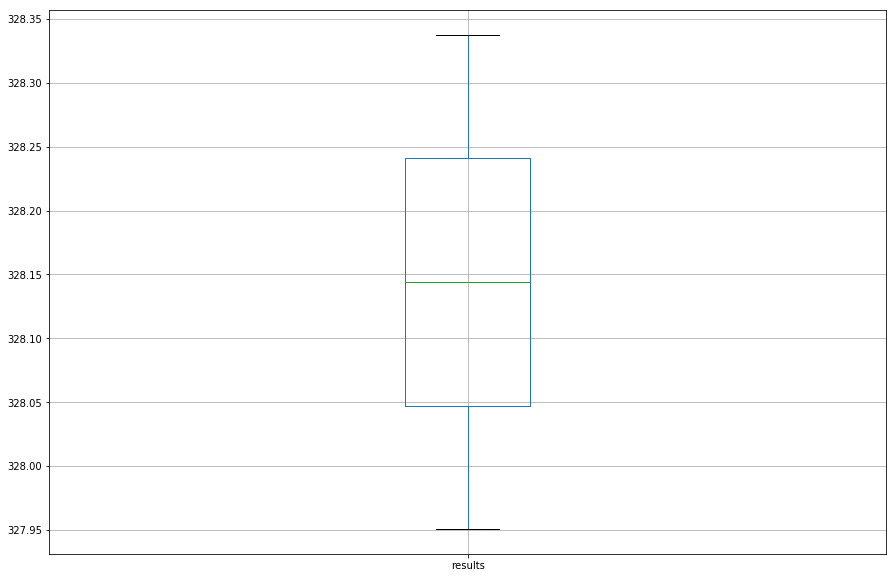

In [33]:
# configure a repeated experiment
# batch size should remain at 1; repeats, epochs and neurons can change
def run():
	n_repeats = 2
	batch_size = 1
	n_epochs = 10
	n_neurons = 100
	# run the experiment
	results = pd.DataFrame()
	results['results'] = experiment(n_repeats, batch_size, n_epochs, n_neurons)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment.csv', index=False)
    # save boxplot
	results.boxplot()
	plt.show()
 
# entry point
run()

### Single run model
This just runs a single model, and you can then plot the predicted vs. actual test values in the bottom cell.

In [34]:
lstm_model = fit_lstm(train_scaled, 1, 10, 100)

Epoch 1/1
 - 6s - loss: 0.0131
Epoch 1/1
 - 4s - loss: 0.0116
Epoch 1/1
 - 4s - loss: 0.0115
Epoch 1/1
 - 4s - loss: 0.0114
Epoch 1/1
 - 4s - loss: 0.0113
Epoch 1/1
 - 4s - loss: 0.0113
Epoch 1/1
 - 4s - loss: 0.0112
Epoch 1/1
 - 3s - loss: 0.0111
Epoch 1/1
 - 4s - loss: 0.0111
Epoch 1/1
 - 4s - loss: 0.0110


In [35]:
predictions = list()
for i in range(len(test_scaled)):
	# predict
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
# report performance
rmse = sqrt(mean_squared_error(raw_values[-600:], predictions))
print('%d) Test RMSE: %.3f' % (1 ,rmse))

1) Test RMSE: 327.979


In [36]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (1, 1, 100)               43200     
_________________________________________________________________
lstm_10 (LSTM)               (1, 1, 20)                9680      
_________________________________________________________________
lstm_11 (LSTM)               (1, 1, 10)                1240      
_________________________________________________________________
lstm_12 (LSTM)               (1, 5)                    320       
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    6         
Total params: 54,446
Trainable params: 54,446
Non-trainable params: 0
_________________________________________________________________


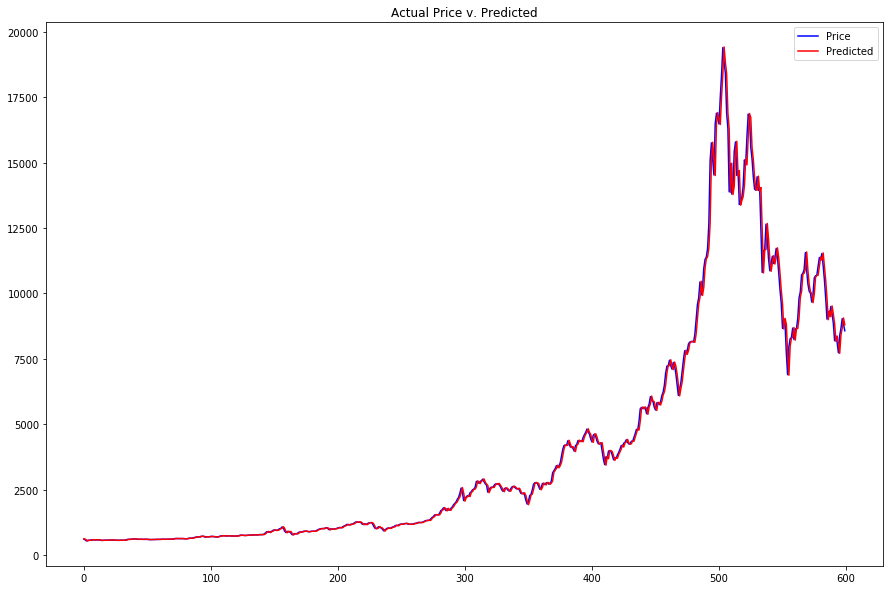

In [37]:
#Plot actual versus predicted:
orig = plt.plot(raw_values[-600:], color='blue',label='Price')
pred = plt.plot(predictions, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('Actual Price v. Predicted')
plt.show()

In [38]:
pd.DataFrame(predictions).to_csv('predict_3_24.csv'); new_df.to_csv('new_df_3_24.csv')

In [39]:
pd.DataFrame(raw_values[-600:]).to_csv('raw_values_3_24.csv')

## Backtesting

In [40]:
finaldf = pd.DataFrame()

In [41]:
finaldf['yhat'] = predictions
finaldf['actual'] = raw_values[-600:]

## Strategy 1 ( Long only)

In [46]:
#Strategy is Starting with $10,000. If we are predicting higher price tomorrow, we are going long.  
#If we are long and predicting lower, we are closing the position.
long = False
ballance = 10000
position = 0
tbalance = 0

for i in range(1,len(finaldf)):
    if finaldf['yhat'][i] > finaldf['actual'][i-1] and not long:
        position = ballance/finaldf['actual'][i-1]
        ballance = ballance - finaldf['actual'][i-1]*position
        long = True
        print("Action: Buy", "\t" "price", finaldf['actual'][i-1], "\t" "Balance: ", ballance )
    if finaldf['yhat'][i] < finaldf['actual'][i-1] and long:
        ballance = ballance + position*finaldf['actual'][i-1]
        #tbalance = tbalance + (position*finaldf['actual'][i-1] -10000)
        position = 0
        long = False
        print("Action: sell","\t" "price", finaldf['actual'][i-1], "\t" "Balance: ", ballance)
    if i == len(finaldf) and long:
        ballance = ballance + position*finaldf['actual'][i]
        position = 0
        long = False
        print("Closed long")
    

#Final PNL
ballance     

Action: Buy 	price 572.7381783 	Balance:  0.0
Action: sell 	price 575.2887645 	Balance:  10044.5331968
Action: Buy 	price 590.3341071 	Balance:  1.81898940355e-12
Action: sell 	price 587.0532616 	Balance:  9988.70961969
Action: Buy 	price 590.8177185 	Balance:  0.0
Action: sell 	price 587.3153874 	Balance:  9929.49716337
Action: Buy 	price 587.2248494 	Balance:  0.0
Action: sell 	price 576.646713 	Balance:  9750.62943411
Action: Buy 	price 573.1198682 	Balance:  0.0
Action: sell 	price 582.1518103 	Balance:  9904.29208895
Action: Buy 	price 579.3445188 	Balance:  0.0
Action: sell 	price 574.3260664 	Balance:  9818.49820156
Action: Buy 	price 575.1770015 	Balance:  -1.81898940355e-12
Action: sell 	price 574.2403722 	Balance:  9802.50957011
Action: Buy 	price 575.319578 	Balance:  0.0
Action: sell 	price 622.9217192 	Balance:  10613.572608
Action: Buy 	price 612.321211 	Balance:  0.0
Action: sell 	price 611.002838 	Balance:  10590.7207986
Action: Buy 	price 609.2911064 	Balance:  0.0
Act

555285.11060155509

## Strategy 2 ( Long / Short )

In [65]:
#Strategy is Starting with $10,000. Long/short.
long = False
short = False
ballance = 10000
longposition = 0
shortposition = 0

for i in range(1,len(finaldf)):
    if finaldf['yhat'][i] > finaldf['actual'][i-1] and not long and not short:
        longposition = ballance/finaldf['actual'][i-1]
        ballance = 0
        long = True
        print("Action: none, going long", "\t""price: ", finaldf['actual'][i-1], "\t""amount long: ", longposition, "\t""Ballance: ",ballance)
        
    if finaldf['yhat'][i] < finaldf['actual'][i-1] and not long and not short:
        shortposition = ballance/finaldf['actual'][i-1]
        ballance = ballance + finaldf['actual'][i-1]*(shortposition)
        short = True
        print("none, going short", "\t" "price: ", finaldf['actual'][i-1], "\t""amount short: ", shortposition, "\t""Ballance: ", ballance )
        
    if finaldf['yhat'][i] < finaldf['actual'][i-1] and long:
        ballance = ballance + longposition*finaldf['actual'][i-1] # sell
        longposition=0
        shortposition = ballance/finaldf['actual'][i-1] #short
        ballance = ballance + finaldf['actual'][i-1]*(ballance/finaldf['actual'][i-1])
        long = False
        short = True
        print("long, going short", "\t""price: ", finaldf['actual'][i-1], "\t""amount short: ", shortposition,"\t""Ballance: ", ballance)
        
    if finaldf['yhat'][i] > finaldf['actual'][i-1] and short:
        ballance = ballance - shortposition*finaldf['actual'][i-1] #cover
        shorptosition = 0
        short = False
        longposition = ballance/finaldf['actual'][i-1] # go long
        ballance = 0
        long = True
        print("short, going long", "\t""price: ", finaldf['actual'][i-1], "\t""amount long: ", longposition, "\t""Ballance: ",ballance)     
    
    if i == (len(finaldf)-1):
        if long:
            ballance = ballance + position*finaldf['actual'][i]
            position = 0
            long = False
            print("Closing long")
        if short:
            ballance = ballance - shortposition*finaldf['actual'][i]
            position = 0
            short = False
            print("Covered short")
        
        #print("Cashing out")
    

#Final PNL
ballance     

none, going short 	price:  620.2563179 	amount short:  16.1223670141 	Ballance:  20000.0
short, going long 	price:  572.7381783 	amount long:  18.7976029788 	Ballance:  0
long, going short 	price:  575.2887645 	amount short:  18.7976029788 	Ballance:  21628.0995864
short, going long 	price:  590.3341071 	amount long:  17.8394459844 	Ballance:  0
long, going short 	price:  587.0532616 	amount short:  17.8394459844 	Ballance:  20945.4099005
short, going long 	price:  590.8177185 	amount long:  17.6121141917 	Ballance:  0
long, going short 	price:  587.3153874 	amount short:  17.6121141917 	Ballance:  20687.7313389
short, going long 	price:  587.2248494 	amount long:  17.6175450436 	Ballance:  0
long, going short 	price:  576.646713 	amount short:  17.6175450436 	Ballance:  20318.1988811
short, going long 	price:  573.1198682 	amount long:  17.8343734964 	Ballance:  0
long, going short 	price:  582.1518103 	amount short:  17.8343734964 	Ballance:  20764.625633
short, going long 	price:  5

short, going long 	price:  5867.672445 	amount long:  36.2767099737 	Ballance:  0
long, going short 	price:  7242.528449 	amount short:  36.2767099737 	Ballance:  525470.208042
short, going long 	price:  7362.433088 	amount long:  35.095104447 	Ballance:  0
long, going short 	price:  7242.265132 	amount short:  35.095104447 	Ballance:  508336.102481
short, going long 	price:  6352.721124 	amount long:  44.9235352128 	Ballance:  0
long, going short 	price:  7687.199527 	amount short:  44.9235352128 	Ballance:  690672.357279
short, going long 	price:  7807.453823 	amount long:  43.539665843 	Ballance:  0
long, going short 	price:  8144.307383 	amount short:  43.539665843 	Ballance:  709200.843958
short, going long 	price:  8439.600966 	amount long:  40.4928431363 	Ballance:  0
long, going short 	price:  9946.465749 	amount short:  40.4928431363 	Ballance:  805521.35467
short, going long 	price:  10209.38848 	amount long:  38.4072159856 	Ballance:  0
long, going short 	price:  15147.33044

1554623.4695976053

## Strategy 3 Buy and Hold

In [51]:
#Buying in with 10000 holding and selling at the end of test window.
(10000/finaldf['actual'][0])*finaldf['actual'][599]

138239.04864089415